<a href="https://colab.research.google.com/github/Poluianov-Vladyslav/Neyron_lab6/blob/main/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import shutil
import os

dataset_dir = '/content/dataset'
if os.path.exists(dataset_dir):
    shutil.rmtree(dataset_dir)
    print(f"Папку '{dataset_dir}' та всі її файли видалено.")
else:
    print(f"Папка '{dataset_dir}' не існує.")

In [ ]:
import os
logo_dir = '/content/drive/MyDrive/logos'
background_dir = '/content/drive/MyDrive/backgrounds'
output_dir = '/content/dataset'
splits = ['train', 'val', 'test']
classes = ['positive', 'negative']
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

In [ ]:
import random
from PIL import Image
from tqdm import tqdm

def augment_logo(logo, bg):
    angle = random.uniform(-30, 30)
    logo = logo.rotate(angle, expand=True)

    max_scale = min(bg.width / logo.width, bg.height / logo.height, 0.4)
    scale = random.uniform(0.2, max_scale)  # 20-40% від фону
    w, h = logo.size
    logo = logo.resize((int(w * scale), int(h * scale)))

    alpha = random.uniform(0.5, 1.0)
    logo.putalpha(int(255 * alpha))
    return logo

logo_files = [os.path.join(logo_dir, f) for f in os.listdir(logo_dir) if f.endswith(('.png','.jpg','.jpeg'))]
background_files = [os.path.join(background_dir, f) for f in os.listdir(background_dir) if f.endswith(('.png','.jpg','.jpeg'))]

total_positive = 2000
total_negative = 2000

split_ratios = {'train':0.7,'val':0.15,'test':0.15}
def get_split_name(idx, total):
    val_thresh = int(total * split_ratios['train'])
    test_thresh = int(total * (split_ratios['train'] + split_ratios['val']))
    if idx < val_thresh:
        return 'train'
    elif idx < test_thresh:
        return 'val'
    else:
        return 'test'

In [ ]:
i = 0
pbar = tqdm(total=total_positive, desc='Generating positive samples')
while i < total_positive:
    bg_path = random.choice(background_files)
    logo_path = random.choice(logo_files)
    try:
        bg = Image.open(bg_path).convert('RGB')
        logo = Image.open(logo_path).convert('RGBA')
    except Exception as e:
        print(f"Error opening image: {e}")
        continue

    bg = Image.open(bg_path).convert('RGB')
    logo = Image.open(logo_path).convert('RGBA')
    logo = augment_logo(logo, bg)
    if logo.width > bg.width or logo.height > bg.height:
        logo.thumbnail((bg.width, bg.height))
    max_x = bg.width - logo.width
    max_y = bg.height - logo.height
    if max_x < 0 or max_y < 0:
        continue
    x = random.randint(0, max_x)
    y = random.randint(0, max_y)
    bg.paste(logo, (x, y), logo)
    split = get_split_name(i, total_positive)
    bg.save(os.path.join(output_dir, split, 'positive', f'pos_{i}.jpg'))
    i += 1
    pbar.update(1)
pbar.close()

Generating positive samples: 100%|██████████| 2000/2000 [01:03<00:00, 31.74it/s]


In [ ]:
i = 0
pbar = tqdm(total=total_negative, desc='Generating negative samples')
while i < total_negative:
    bg_path = random.choice(background_files)
    try:
        bg = Image.open(bg_path).convert('RGB')
    except Exception as e:
        print(f"Error opening background image: {e}")
        continue
    split = get_split_name(i, total_negative)
    bg.save(os.path.join(output_dir, split, 'negative', f'neg_{i}.jpg'))
    i += 1
    pbar.update(1)
pbar.close()

Generating negative samples: 100%|██████████| 2000/2000 [00:07<00:00, 280.11it/s]


In [ ]:
dataset_dir = '/content/dataset'
total_files = 0
for split in splits:
    for cls in classes:
        path = os.path.join(dataset_dir, split, cls)
        n = len([f for f in os.listdir(path) if f.endswith(('.png','.jpg','.jpeg'))])
        print(f"{split}/{cls}: {n} files")
        total_files += n

print(f"Total files in dataset: {total_files}")

train/positive: 1400 files
train/negative: 1400 files
val/positive: 300 files
val/negative: 300 files
test/positive: 300 files
test/negative: 300 files
Total files in dataset: 4000


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_size = (150,150)
batch_size = 32
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    directory=os.path.join(output_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = datagen.flow_from_directory(
    directory=os.path.join(output_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    directory=os.path.join(output_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from keras import layers, models
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

def build_xception(input_shape=(150,150,3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), strides=(2,2), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    residual = layers.Conv2D(128, (1,1), strides=(2,2), padding='same')(x)
    residual = layers.BatchNormalization()(residual)

    x = layers.SeparableConv2D(128, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(128, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = layers.add([x, residual])

    residual = layers.Conv2D(256, (1,1), strides=(2,2), padding='same')(x)
    residual = layers.BatchNormalization()(residual)

    x = layers.SeparableConv2D(256, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(256, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = layers.add([x, residual])

    for i in range(4):
        residual = x
        x = layers.SeparableConv2D(256, (3,3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(256, (3,3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(256, (3,3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.add([x, residual])
        x = layers.Activation('relu')(x)

    residual = layers.Conv2D(512, (1,1), strides=(2,2), padding='same')(x)
    residual = layers.BatchNormalization()(residual)

    x = layers.SeparableConv2D(256, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(512, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
    x = layers.add([x, residual])

    x = layers.SeparableConv2D(512, (3,3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes)(x)  # logits

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

model = build_xception()
model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 75, 75,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 75, 75,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 75, 75,    │     18,496 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 75, 75,    │      8,896 │ activation_1[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 75, 75,    │     17,664 │ activation_2[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 38, 38,    │      8,320 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 38, 38,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 38, 38,    │          0 │ max_pooling2d[0]… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 38, 38,    │     34,176 │ add[0][0]       

 Total params: 1,697,793 (6.48 MB)

 Trainable params: 1,685,569 (6.43 MB)

 Non-trainable params: 12,224 (47.75 KB)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 104s 638ms/step - accuracy: 0.7857 - loss: 0.4452 - val_accuracy: 0.5000 - val_loss: 0.7099
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 0.9409 - loss: 0.1631 - val_accuracy: 0.5000 - val_loss: 0.8430
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - accuracy: 0.9654 - loss: 0.1018 - val_accuracy: 0.5000 - val_loss: 1.3823
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.9802 - loss: 0.0735 - val_accuracy: 0.5000 - val_loss: 2.3545
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9817 - loss: 0.0605 - val_accuracy: 0.5000 - val_loss: 2.6559
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.9895 - loss: 0.0372 - val_accuracy: 0.5000 - val_loss: 2.9914
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.9903 - loss: 0.0349 - val_accuracy: 0.7933 - val_loss: 0.7170
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.9937 - loss: 0.0211 - val_accuracy: 0.96

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

print("\nEvaluating on test data...")
test_logits = model.predict(test_generator)
test_probs = tf.nn.sigmoid(test_logits).numpy().flatten()
test_preds = (test_probs > 0.5).astype(int)
test_labels = test_generator.labels
test_acc = np.mean(test_preds == test_labels)
print(f"Test accuracy: {test_acc:.4f}")

cm = confusion_matrix(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)

print("Confusion Matrix:\n", cm)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


Evaluating on test data...
19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 371ms/step
Test accuracy: 0.9983
Confusion Matrix:
 [[300   0]
 [  1 299]]
Precision: 1.0000, Recall: 0.9967, F1-score: 0.9983


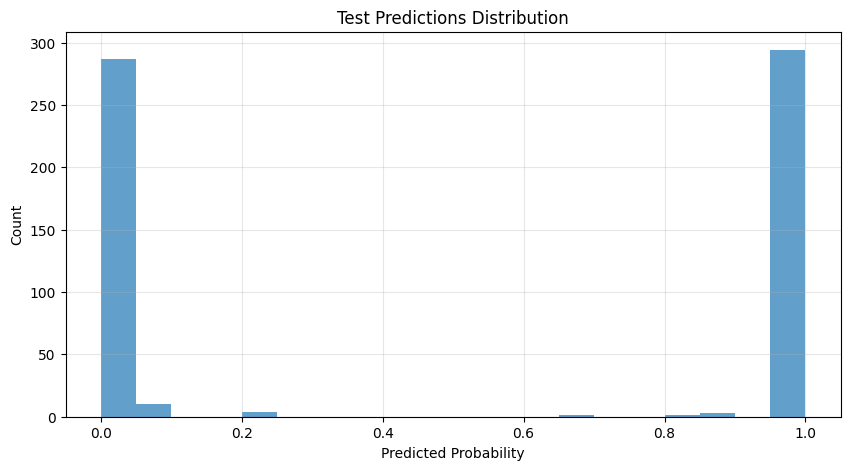

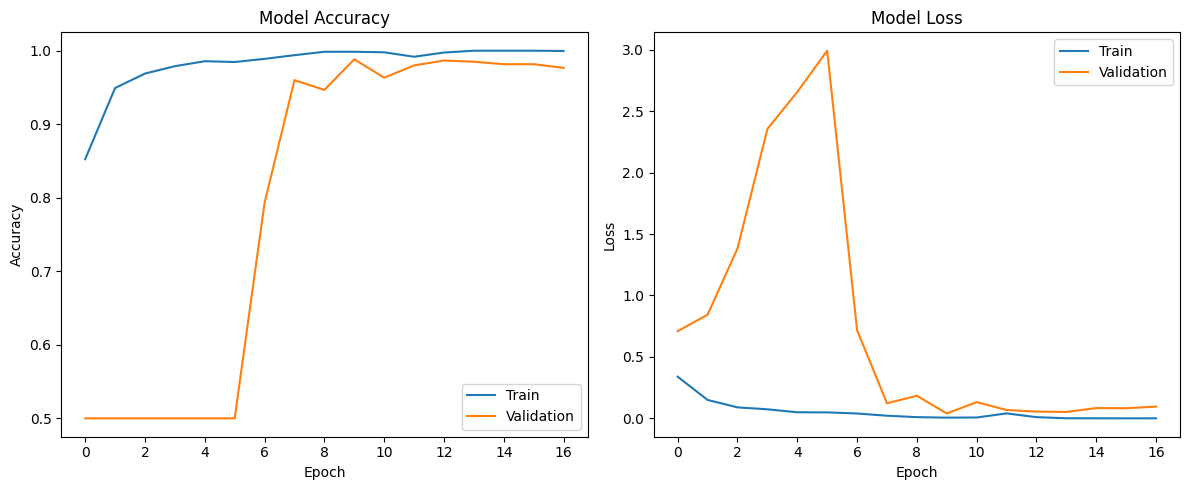

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(test_probs, bins=20, alpha=0.7)
plt.title('Test Predictions Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.grid(alpha=0.3)
plt.savefig('/content/drive/MyDrive/test_predictions.png')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/training_history.png')

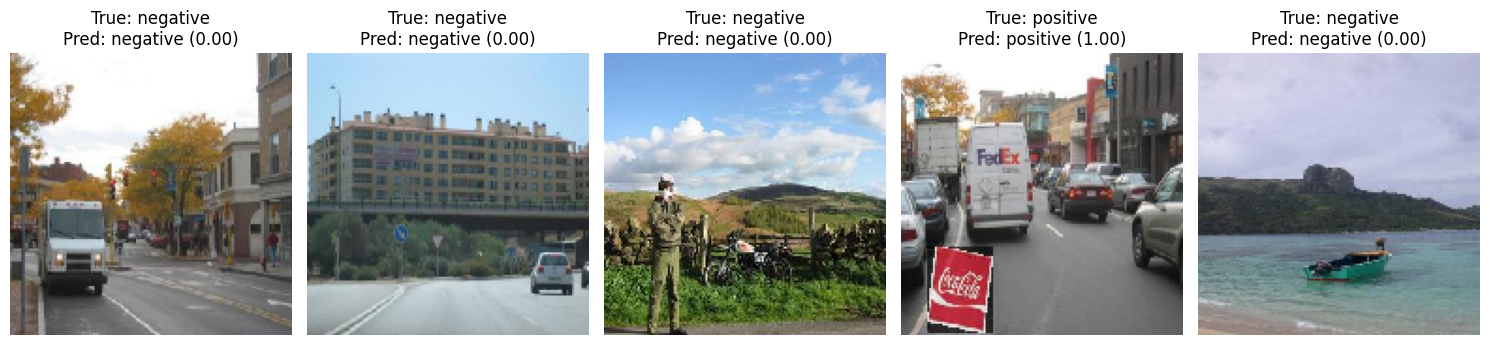

In [ ]:
num_samples = 5

class_names = list(train_generator.class_indices.keys())
num_test_samples = len(test_generator.labels)
random_indices = random.sample(range(num_test_samples), num_samples)
plt.figure(figsize=(15, 10))

for i, index in enumerate(random_indices):

    image_path = test_generator.filepaths[index]
    true_label = test_generator.labels[index]

    img = tf.keras.utils.load_img(image_path, target_size=model.input_shape[1:3])
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    predictions = model.predict(img_array, verbose=0)
    prob = tf.nn.sigmoid(predictions).numpy().flatten()[0]

    predicted_class = 1 if prob > 0.5 else 0

    predicted_label = class_names[predicted_class]
    true_label_name = class_names[true_label]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.title(
        f"True: {true_label_name}\n"
        f"Pred: {predicted_label} ({prob:.2f})"
    )
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import datetime
now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
model_save_path = f'/content/drive/MyDrive/xception_{timestamp}.keras'
model.save(model_save_path)
print(f"Модель успішно збережено за шляхом: {model_save_path}")

Модель успішно збережено за шляхом: /content/drive/MyDrive/xception_20251114_201252.keras


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Detected logo intervals (frame numbers): [(71, 71), (73, 364)]


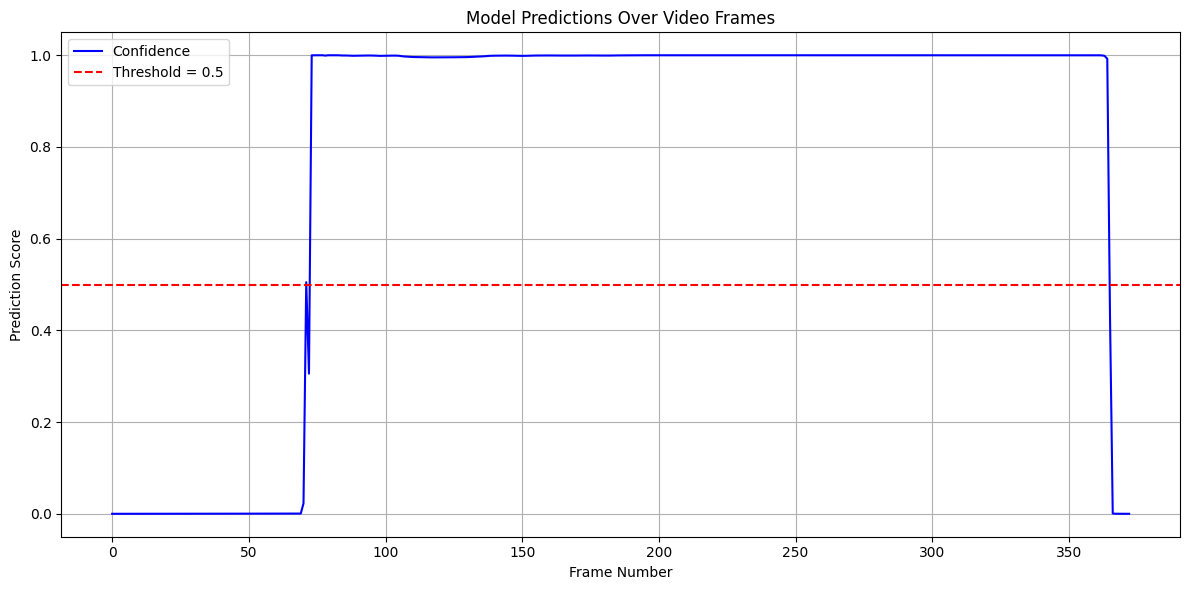

In [ ]:
import cv2

video_path = '/content/drive/MyDrive/coca_cola2.mp4'
cap = cv2.VideoCapture(video_path)
batch_size = 32
frames, frames_ids, frame_predictions, frame_numbers = [], [], [], []
frame_count = 0

def process_batch(batch_frames, batch_ids):
    batch_np = np.array(batch_frames).astype(np.float32)/255.0
    predictions = model.predict(batch_np)
    for i in range(len(predictions)):
        score = 1/(1+np.exp(-predictions[i][0]))
        frame_predictions.append(score)
        frame_numbers.append(batch_ids[i])

while True:
    ret, frame = cap.read()
    if not ret:
        break
    resized_frame = cv2.resize(frame,(150,150))
    frames.append(resized_frame)
    frames_ids.append(frame_count)
    if len(frames) == batch_size:
        process_batch(frames, frames_ids)
        frames, frames_ids = [], []
    frame_count += 1

if frames:
    process_batch(frames, frames_ids)
cap.release()

threshold = 0.5
intervals = []
start = None
for i, score in zip(frame_numbers, frame_predictions):
    if score > threshold and start is None:
        start = i
    elif score <= threshold and start is not None:
        intervals.append((start, i-1))
        start = None
if start is not None:
    intervals.append((start, frame_numbers[-1]))

print("Detected logo intervals (frame numbers):", intervals)

plt.figure(figsize=(12,6))
plt.plot(frame_numbers, frame_predictions, label='Confidence', color='blue')
plt.axhline(threshold,color='red',linestyle='--',label=f'Threshold = {threshold}')
plt.xlabel('Frame Number')
plt.ylabel('Prediction Score')
plt.title('Model Predictions Over Video Frames')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()